In [1]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.vgg16 import (
    VGG16, preprocess_input, decode_predictions)
from keras.preprocessing import image
from keras.layers.core import Lambda
from keras.models import Sequential
from tensorflow.python.framework import ops
import keras.backend as K
import tensorflow as tf
import numpy as np
import keras
import sys
import cv2

import keras
import tensorflow as tf

from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [2]:
label_list = [i for i in range(10)]

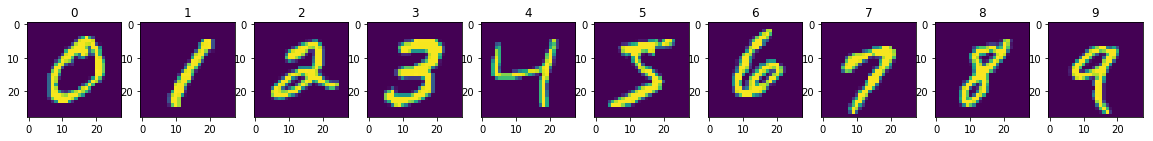

In [3]:
plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(1,10,i+1)
    coord = np.where(y_train.flatten() == i)[0][0]
    plt.imshow(x_train[coord])
    plt.title(label_list[y_train[coord]])

plt.show()

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="1";  
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.compat.v1.Session(config=config)

In [7]:
model = keras.models.load_model('../../models/mnist_gradcam.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## Saliency

![Screenshot from 2019-11-15 12-56-30](https://user-images.githubusercontent.com/33189954/68916005-95a87700-07a7-11ea-9800-00fcedab36d1.png)

In [43]:
idx = 3

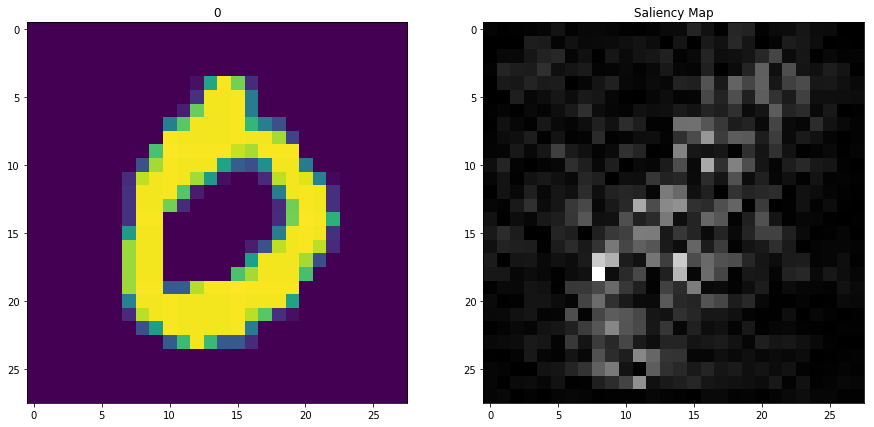

In [75]:
def get_saliency(idx, model):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    return saliency([x_train[idx][np.newaxis,...,np.newaxis]/255])

grads_orig = get_saliency(idx, model)
s_map = np.abs(grads_orig[0][0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(122)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.show()

# SmoothGrad
![Screenshot from 2019-11-15 12-59-28](https://user-images.githubusercontent.com/33189954/68916071-d0121400-07a7-11ea-9c3b-379e40782747.png)

In [76]:
def get_smoothgrad(idx,model,n = 10, sigma = 1):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    result = np.zeros_like(img_input)
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma,size=img_input.shape)])[0]
        return result / n

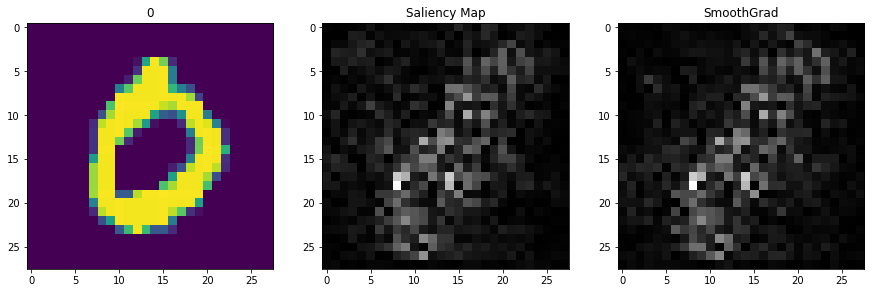

In [77]:
n = 100
sigma = 0.0001

grads_output = get_smoothgrad(idx, model, n, sigma)
sgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(132)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(133)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.show()

# vargrad

![Screenshot from 2019-11-15 13-27-12](https://user-images.githubusercontent.com/33189954/68917001-b377db00-07ab-11ea-8cc3-21d670b1cad7.png)

In [78]:
def get_vargrad(idx, model, n=10, sigma=1):
    y_c = model.output[0, idx]
    grads = keras.backend.gradients(y_c, model.input)[0]
    saliency = keras.backend.function([model.input], [grads])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    
    smoothgrad = np.zeros_like(img_input)
    result = np.zeros_like(img_input)
    for i in range(n):
        smoothgrad += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]
    
    smoothgrad /= n
    
    for i in range(n):
        result += saliency([img_input + np.random.normal(scale=sigma, size=img_input.shape)])[0]**2 - smoothgrad**2
    
    return result / n

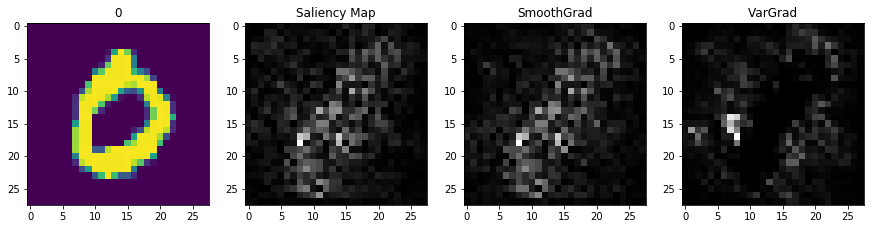

In [79]:

n = 10
sigma = .0001

grads_output = get_vargrad(idx, model, n, sigma)

vgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

# Integrated gradients
![Screenshot from 2019-11-15 13-28-51](https://user-images.githubusercontent.com/33189954/68917039-e15d1f80-07ab-11ea-893b-237b7af6fa58.png)


In [80]:
def get_integratedgrad(idx, model,step= 50, baseline=None):
    y_c = model.output[0,idx]
    grad = keras.backend.gradients(y_c,model.input)[0]
    saliency = keras.backend.function([model.input],[grad])
    img_input = x_train[idx][np.newaxis,...,np.newaxis]/255
    
    if baseline is None:
        baseline = 0 * img_input
    assert baseline.shape == img_input.shape
    temp = np.zeros_like(img_input)

    inputs = [baseline + (float(j)/step * img_input-baseline) for j in range(step +1)]
    for inp in inputs:
        temp +=saliency([inp])[0]
    return (img_input-baseline) * temp / step

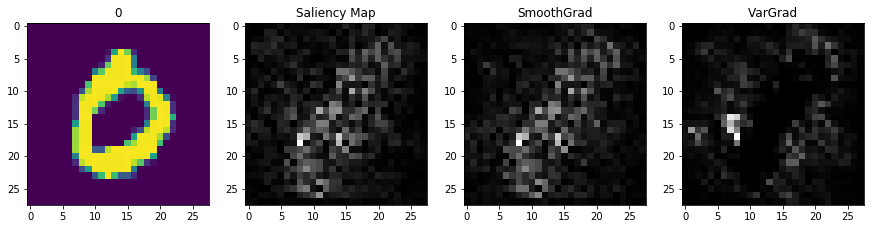

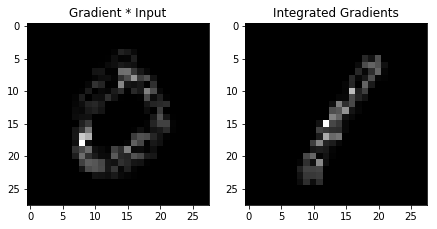

In [81]:
grads_output = get_integratedgrad(idx, model)
integratedgrad = np.abs(grads_output[0].mean(axis=-1))

plt.figure(figsize=(15,15))
plt.subplot(141)
plt.imshow(x_test[idx])
plt.title(label_list[y_test[idx]])
plt.subplot(142)
plt.imshow(s_map, 'gray')
plt.title('Saliency Map')
plt.subplot(143)
plt.imshow(sgrad, 'gray')
plt.title('SmoothGrad')
plt.subplot(144)
plt.imshow(vgrad, 'gray')
plt.title('VarGrad')
plt.show()

plt.figure(figsize=(15,15))
plt.subplot(141)
plot5 = np.abs(x_test[idx]*np.squeeze(grads_orig[0]))
plt.imshow(plot5, 'gray')
plt.title('Gradient * Input')
plt.subplot(142)
plt.imshow(integratedgrad, 'gray')
plt.title('Integrated Gradients')
plt.show()

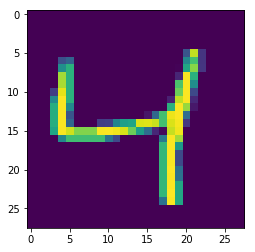

In [82]:
coord = np.where(y_train.flatten() == 4)[0][0]
plt.imshow(x_train[coord])

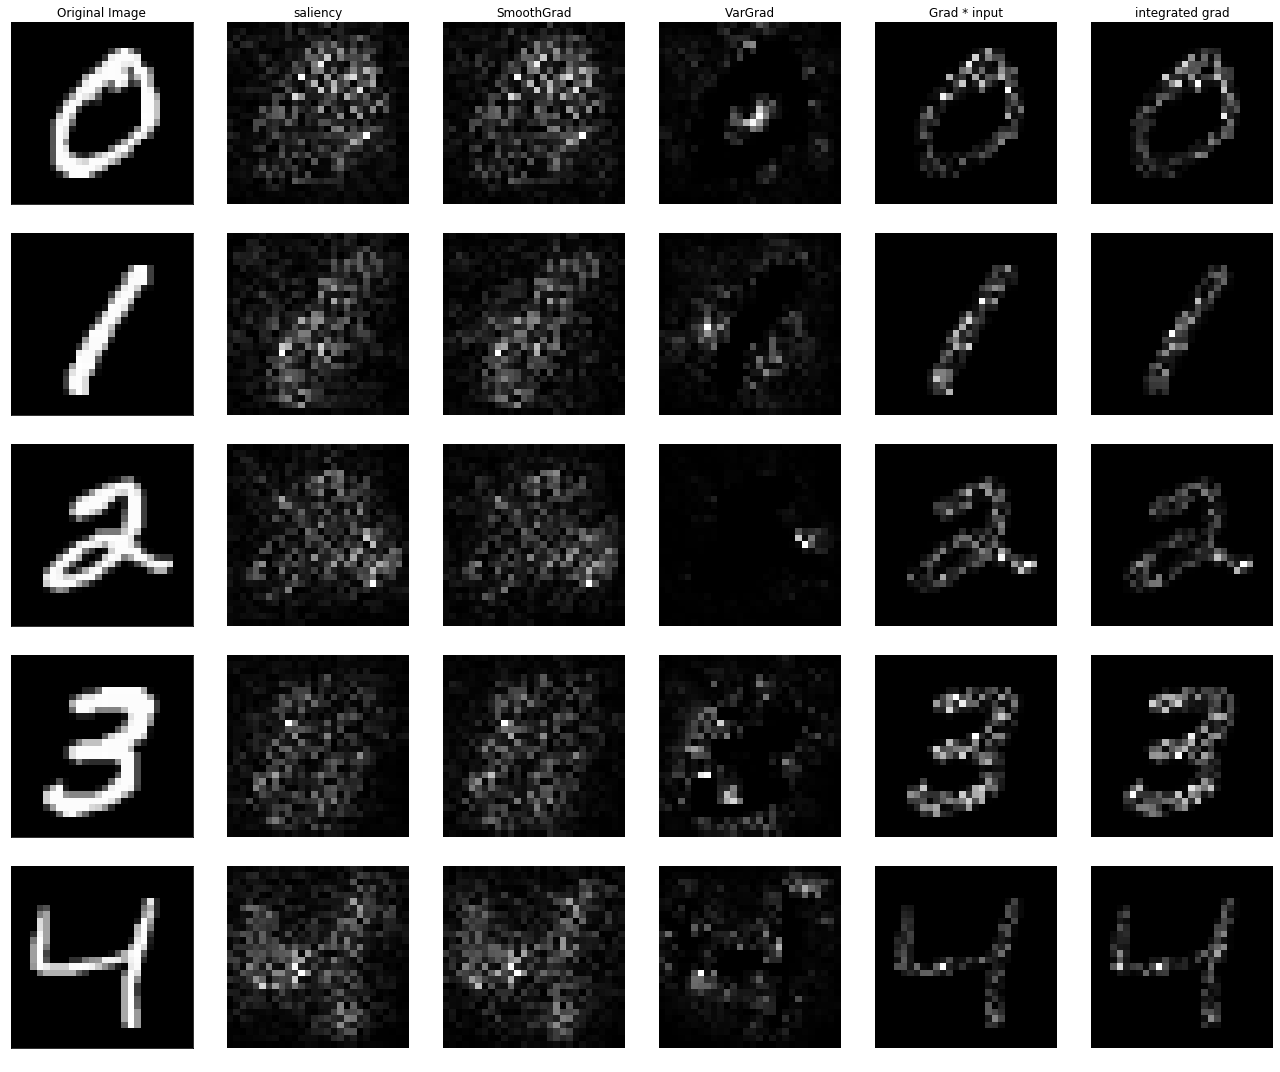

In [89]:
f, ax = plt.subplots(5, 6, figsize=(20, 15))

row = 5
col = 6
color = 'gray'

# coord = np.where(y_train.flatten() == i)[0][0]
# plt.imshow(x_train[coord])

results = []
for i in range(row):
    coord = np.where(y_train.flatten() == i)[0][0]
    target_image = x_train[coord]

    ax[i,0].imshow(target_image, color)
    ax[i,0].set_xticks([])
    ax[i,0].set_yticks([])
    # set title
    if i == 0:
        ax[i,0].set_title('Original Image')

    # saliency
    grads_orig = get_saliency(coord, model)
    s_map = np.abs(grads_orig[0][0].mean(axis=-1))
    # SmoothGrad
    grads_output = get_smoothgrad(coord, model, n, sigma)
    sgrad = np.abs(grads_output[0].mean(axis=-1))
    # VarGrad
    grads_output = get_vargrad(coord, model, n, sigma)
    vgrad = np.abs(grads_output[0].mean(axis=-1))
    # Grad * input
    grad_input = np.abs(x_train[coord]*np.squeeze(grads_orig[0]))
    # integrated grad
    grads_output = get_integratedgrad(coord, model)
    integratedgrad = np.abs(grads_output[0].mean(axis=-1))
    
    results.append([s_map, sgrad, vgrad, grad_input, integratedgrad])
    

names = ['saliency', 'SmoothGrad', 'VarGrad', 'Grad * input', 'integrated grad']
    
for i in range(row*(col-1)):
    r = i//(col-1)
    c = i%(col-1)
    ax[r,c+1].imshow(results[r][c], color)
    ax[r,c+1].axis('off')

    if r == 0:
        ax[r,c+1].set_title(names[c])
plt.subplots_adjust(wspace=-0.5, hspace=0)
plt.tight_layout()